In [41]:
import os, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
DATA_DIR = "PetImages"

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
SEED = 42
torch.manual_seed(SEED)

Device: cpu


In [42]:
# Carregamento, split 80/20 e pré-processamento (TFDS)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [43]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
print("Classes:", class_names)

total_size = len(full_dataset)
print("Tamanho total:", total_size)

train_size = int(0.8 * total_size)
test_size  = total_size - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Tamanho treino: {len(train_dataset)}, teste: {len(test_dataset)}")

Classes: ['cats', 'dogs']
Tamanho total: 24998
Tamanho treino: 19998, teste: 5000


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                            

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  

model = SimpleCNN().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)  
        optimizer.zero_grad()
        outputs = model(images)                
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()

            correct += (preds == labels.int()).sum().item()
            total += images.size(0)

            all_labels.extend(labels.cpu().numpy().ravel())
            all_preds.extend(preds.cpu().numpy().ravel())
    return (
        running_loss / total,
        correct / total,
        np.array(all_labels, dtype=int),
        np.array(all_preds, dtype=int),
    )

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Época {epoch:02d}: "
          f"treino_loss={train_loss:.4f}, treino_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


C:\Users\1448840\AppData\Roaming\Python\Python314\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Época 01: treino_loss=0.5881, treino_acc=0.6822, val_loss=0.5665, val_acc=0.7104
Época 02: treino_loss=0.4726, treino_acc=0.7773, val_loss=0.4561, val_acc=0.7850
Época 03: treino_loss=0.4053, treino_acc=0.8176, val_loss=0.4250, val_acc=0.8020
Época 04: treino_loss=0.3440, treino_acc=0.8532, val_loss=0.3988, val_acc=0.8182
Época 05: treino_loss=0.2803, treino_acc=0.8824, val_loss=0.4217, val_acc=0.8144


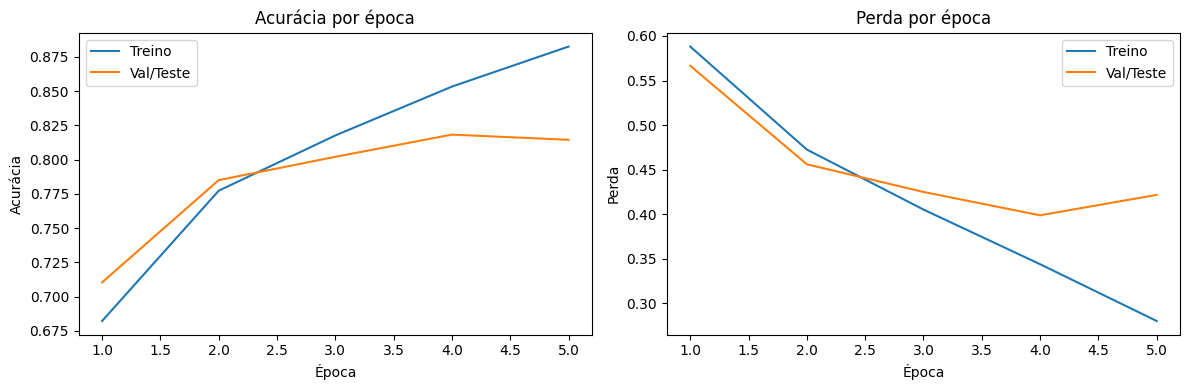

In [46]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_acc"], label="Treino")
plt.plot(epochs_range, history["val_acc"], label="Val/Teste")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.title("Acurácia por época")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_loss"], label="Treino")
plt.plot(epochs_range, history["val_loss"], label="Val/Teste")
plt.xlabel("Época"); plt.ylabel("Perda"); plt.title("Perda por época")
plt.legend()
plt.tight_layout()
plt.show()

Acurácia final no teste: 0.8144

Relatório de classificação:

              precision    recall  f1-score   support

        cats     0.7602    0.9193    0.8322      2504
        dogs     0.8976    0.7091    0.7923      2496

    accuracy                         0.8144      5000
   macro avg     0.8289    0.8142    0.8123      5000
weighted avg     0.8288    0.8144    0.8123      5000



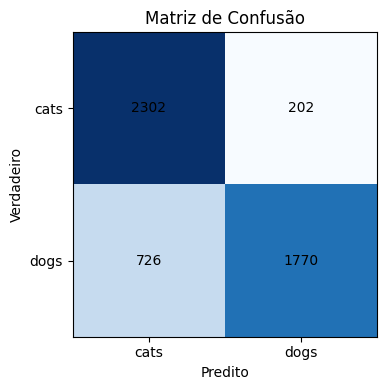

In [47]:
val_loss, val_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"Acurácia final no teste: {val_acc:.4f}")

print("\nRelatório de classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusão")
plt.xticks([0,1], class_names); plt.yticks([0,1], class_names)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

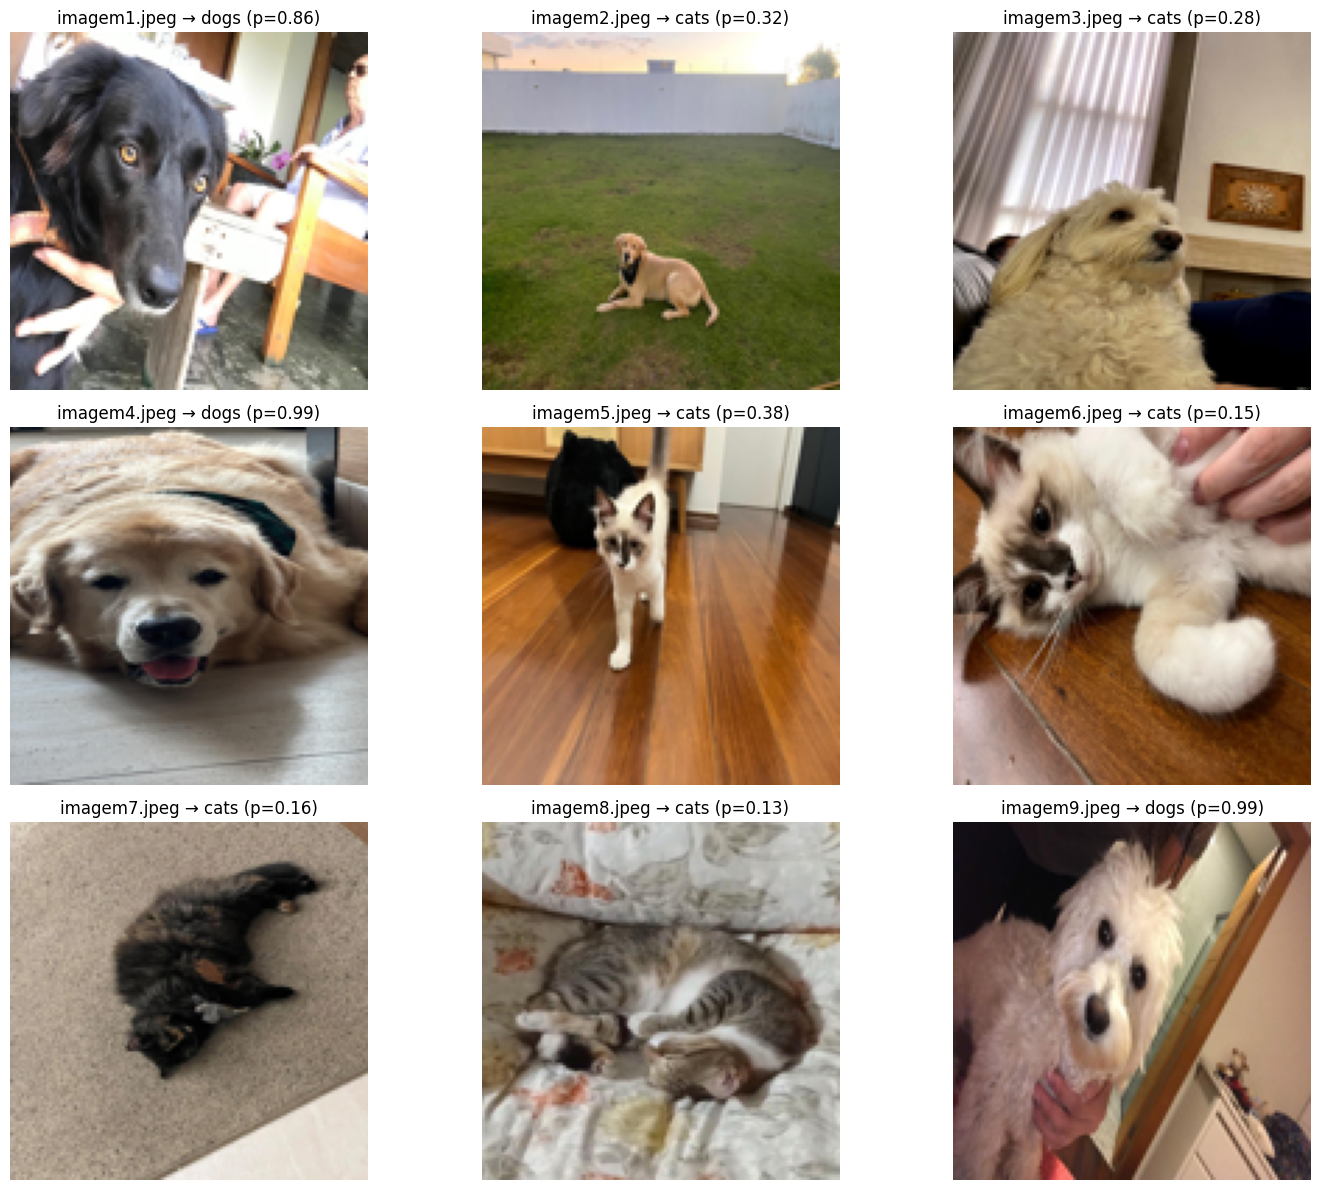

In [49]:
from PIL import Image

novas_imagens = [
    "testeImagens/imagem1.jpeg",
    "testeImagens/imagem2.jpeg",
    "testeImagens/imagem3.jpeg",
    "testeImagens/imagem4.jpeg",
    "testeImagens/imagem5.jpeg",
    "testeImagens/imagem6.jpeg",
    "testeImagens/imagem7.jpeg",
    "testeImagens/imagem8.jpeg",
    "testeImagens/imagem9.jpeg",

]

def preprocess_single_image(path):
    img = Image.open(path).convert("RGB")
    img = test_transform(img)
    return img

if len(novas_imagens) > 0:
    cols = min(3, len(novas_imagens))
    rows = int(np.ceil(len(novas_imagens)/cols))
    plt.figure(figsize=(5*cols, 4*rows))

    model.eval()
    with torch.no_grad():
        for i, p in enumerate(novas_imagens, 1):
            img_tensor = preprocess_single_image(p).unsqueeze(0).to(DEVICE)
            logit = model(img_tensor)
            prob = torch.sigmoid(logit).item()
            pred_idx = 1 if prob >= 0.5 else 0
            pred_name = class_names[pred_idx]
            titulo = f"{os.path.basename(p)} → {pred_name} (p={prob:.2f})"

            img_show = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
            plt.subplot(rows, cols, i)
            plt.imshow(img_show)
            plt.title(titulo); plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Adicione caminhos em 'novas_imagens' para testar inferência.")

In [50]:
torch.save(model.state_dict(), "cnn_cats_vs_dogs_pytorch.pth")
print("Modelo salvo em cnn_cats_vs_dogs_pytorch.pth")

Modelo salvo em cnn_cats_vs_dogs_pytorch.pth
